In [1]:
import pandas as pd
import xarray as xr

from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import datetime as dt
from mpl_toolkits import mplot3d
import matplotlib
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles
import scipy.ndimage as ndimage
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import statistics as stat
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
class ShadedReliefESRI(GoogleTiles):
#    # shaded relief
   def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
              z=z, y=y, x=x)

        return url

C:\Users\python\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
import cartopy
from itertools import product

In [3]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key="4/tAGfV-WYiy78E8S2OYeIihJpMjeexUQkJmo7jKnxlUujPgtP8KvZfhs.") # Your Google API key
average2018 = pd.read_csv("AverageBasinRR.csv", header = None, names = ['dates', 'mm'], parse_dates = ['dates'], index_col=['dates'])

In [4]:
# ds18 = xr.open_dataset('/Desktop/RR_2018_5min.nc')
ds18 = xr.open_dataset('RR_2018_5min.nc')

# find first timestamp
matlab_datenum = ds18.time.values[0]

timestring = str(datetime.fromordinal(int(matlab_datenum)) \
                    + pd.Timedelta(days=matlab_datenum%1) \
                    - pd.Timedelta(days = 366))

first_time = timestring[:19]
new_dates = pd.date_range(first_time, periods=len(ds18.time.values), freq='5min')
ds18['time'] = new_dates
# Bias Correct the Rain Rates due to systematic overestimation by the rain gauge
z_bias =  0.90490945612
kdp_bias =  0.821274341604
ds18['RR_Z_BC'] = ds18.RR_Z * z_bias
ds18['RR_KDP_BC'] = ds18.RR_KDP * kdp_bias
df = ds18.to_dataframe()

In [5]:
df.reset_index(inplace=True)
df.index = df['time']
df.head()


,time,x,y,lat,lon,RR_Z,RR_KDP,RR_Z_BC,RR_KDP_BC
time,,,,,,,,,
2018-05-27 18:05:00,2018-05-27 18:05:00,0,0,38.071188,-78.629851,0.0,0.0,0.0,0.0
2018-05-27 18:05:00,2018-05-27 18:05:00,0,1,38.075695,-78.629922,0.0,0.0,0.0,0.0
2018-05-27 18:05:00,2018-05-27 18:05:00,0,2,38.080202,-78.629993,0.0,0.0,0.0,0.0
2018-05-27 18:05:00,2018-05-27 18:05:00,0,3,38.084710,-78.630063,0.0,0.0,0.0,0.0
2018-05-27 18:05:00,2018-05-27 18:05:00,0,4,38.089217,-78.630134,0.0,0.0,0.0,0.0


In [6]:
data1 = df.groupby(df['time'])['RR_KDP'].mean() * 100
data2 = df.groupby(df['time'])['RR_KDP_BC'].mean() * 100
data3 = df.groupby(df['time'])['RR_Z'].mean() * 100
data4 = df.groupby(df['time'])['RR_Z_BC'].mean() * 100
# Creates pandas DataFrame. 
dfKDP = pd.DataFrame(data1)
dfKDPbc = pd.DataFrame(data2) 
dfZ = pd.DataFrame(data3)
dfZbc = pd.DataFrame(data4)
# print the data 
dfKDPbc
# dfKDPbc
# dfZbc

,RR_KDP_BC
time,
2018-05-27 18:05:00,71.816724
2018-05-27 18:10:00,73.788212
2018-05-27 18:15:00,76.894307
2018-05-27 18:20:00,88.874083
2018-05-27 18:25:00,94.614182
...,...
2018-05-28 01:40:00,35.855120
2018-05-28 01:45:00,34.267214
2018-05-28 01:50:00,31.627449


C:\Users\python\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


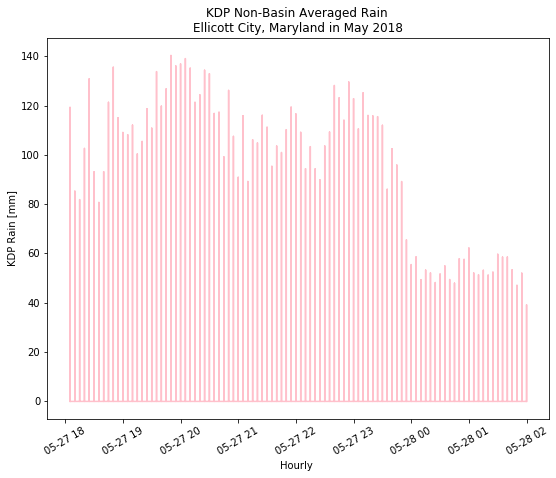

In [7]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(df.index.values,(df['RR_KDP']), '-', color = 'pink')
plt.xticks(rotation =30)
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=.001))
# ax.xaxis.set_major_formatter(DateFormatter("%m/%d %I %p"))
ax.set(xlabel="Hourly ",
       ylabel="KDP Rain [mm]",
       title="KDP Non-Basin Averaged Rain \nEllicott City, Maryland in May 2018")
plt.show()

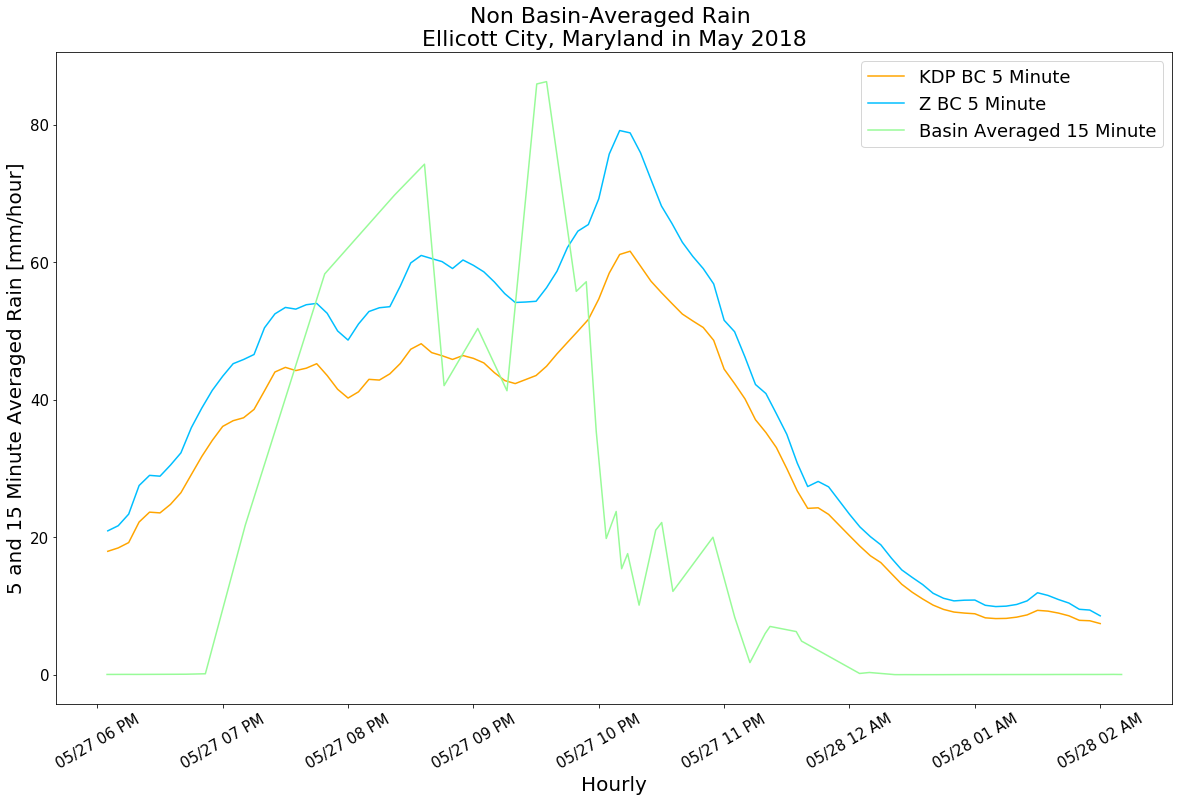

In [8]:
## Analyzing 5 Minute KDP Z datasets
fig, ax = plt.subplots(figsize=(20, 12))
# ax.plot(dfKDP.index.values,dfKDP.RR_KDP, '-', color = 'darkorange')
ax.plot(dfKDPbc.index.values,dfKDPbc.RR_KDP_BC/4, '-', color = 'orange')
# ax.plot(dfZ.index.values,dfZ.RR_Z, '-', color = 'dodgerblue')
ax.plot(dfZbc.index.values,dfZbc.RR_Z_BC/4, '-', color = 'deepskyblue')
ax.plot(average2018.index.values,average2018.mm/4, '-', color = 'palegreen')
plt.xticks(rotation =30)
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=.001))
ax.xaxis.set_major_formatter(DateFormatter("%m/%d %I %p"))
ax.set_title("Non Basin-Averaged Rain \nEllicott City, Maryland in May 2018", fontsize = 22)
ax.set_xlabel('Hourly', fontsize=20)
ax.set_ylabel("5 and 15 Minute Averaged Rain [mm/hour]", fontsize=20)
ax.legend(['KDP BC 5 Minute', 'Z BC 5 Minute', 'Basin Averaged 15 Minute'],  prop={'size': 18})
plt.xticks(rotation =30, fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('2018KDPZAVG.png')
plt.show()

In [9]:
x = np.array(ds18.lat[1])
y = np.array(ds18.lon[1])
c = list(product(x,y))
c = np.array(c)
# c

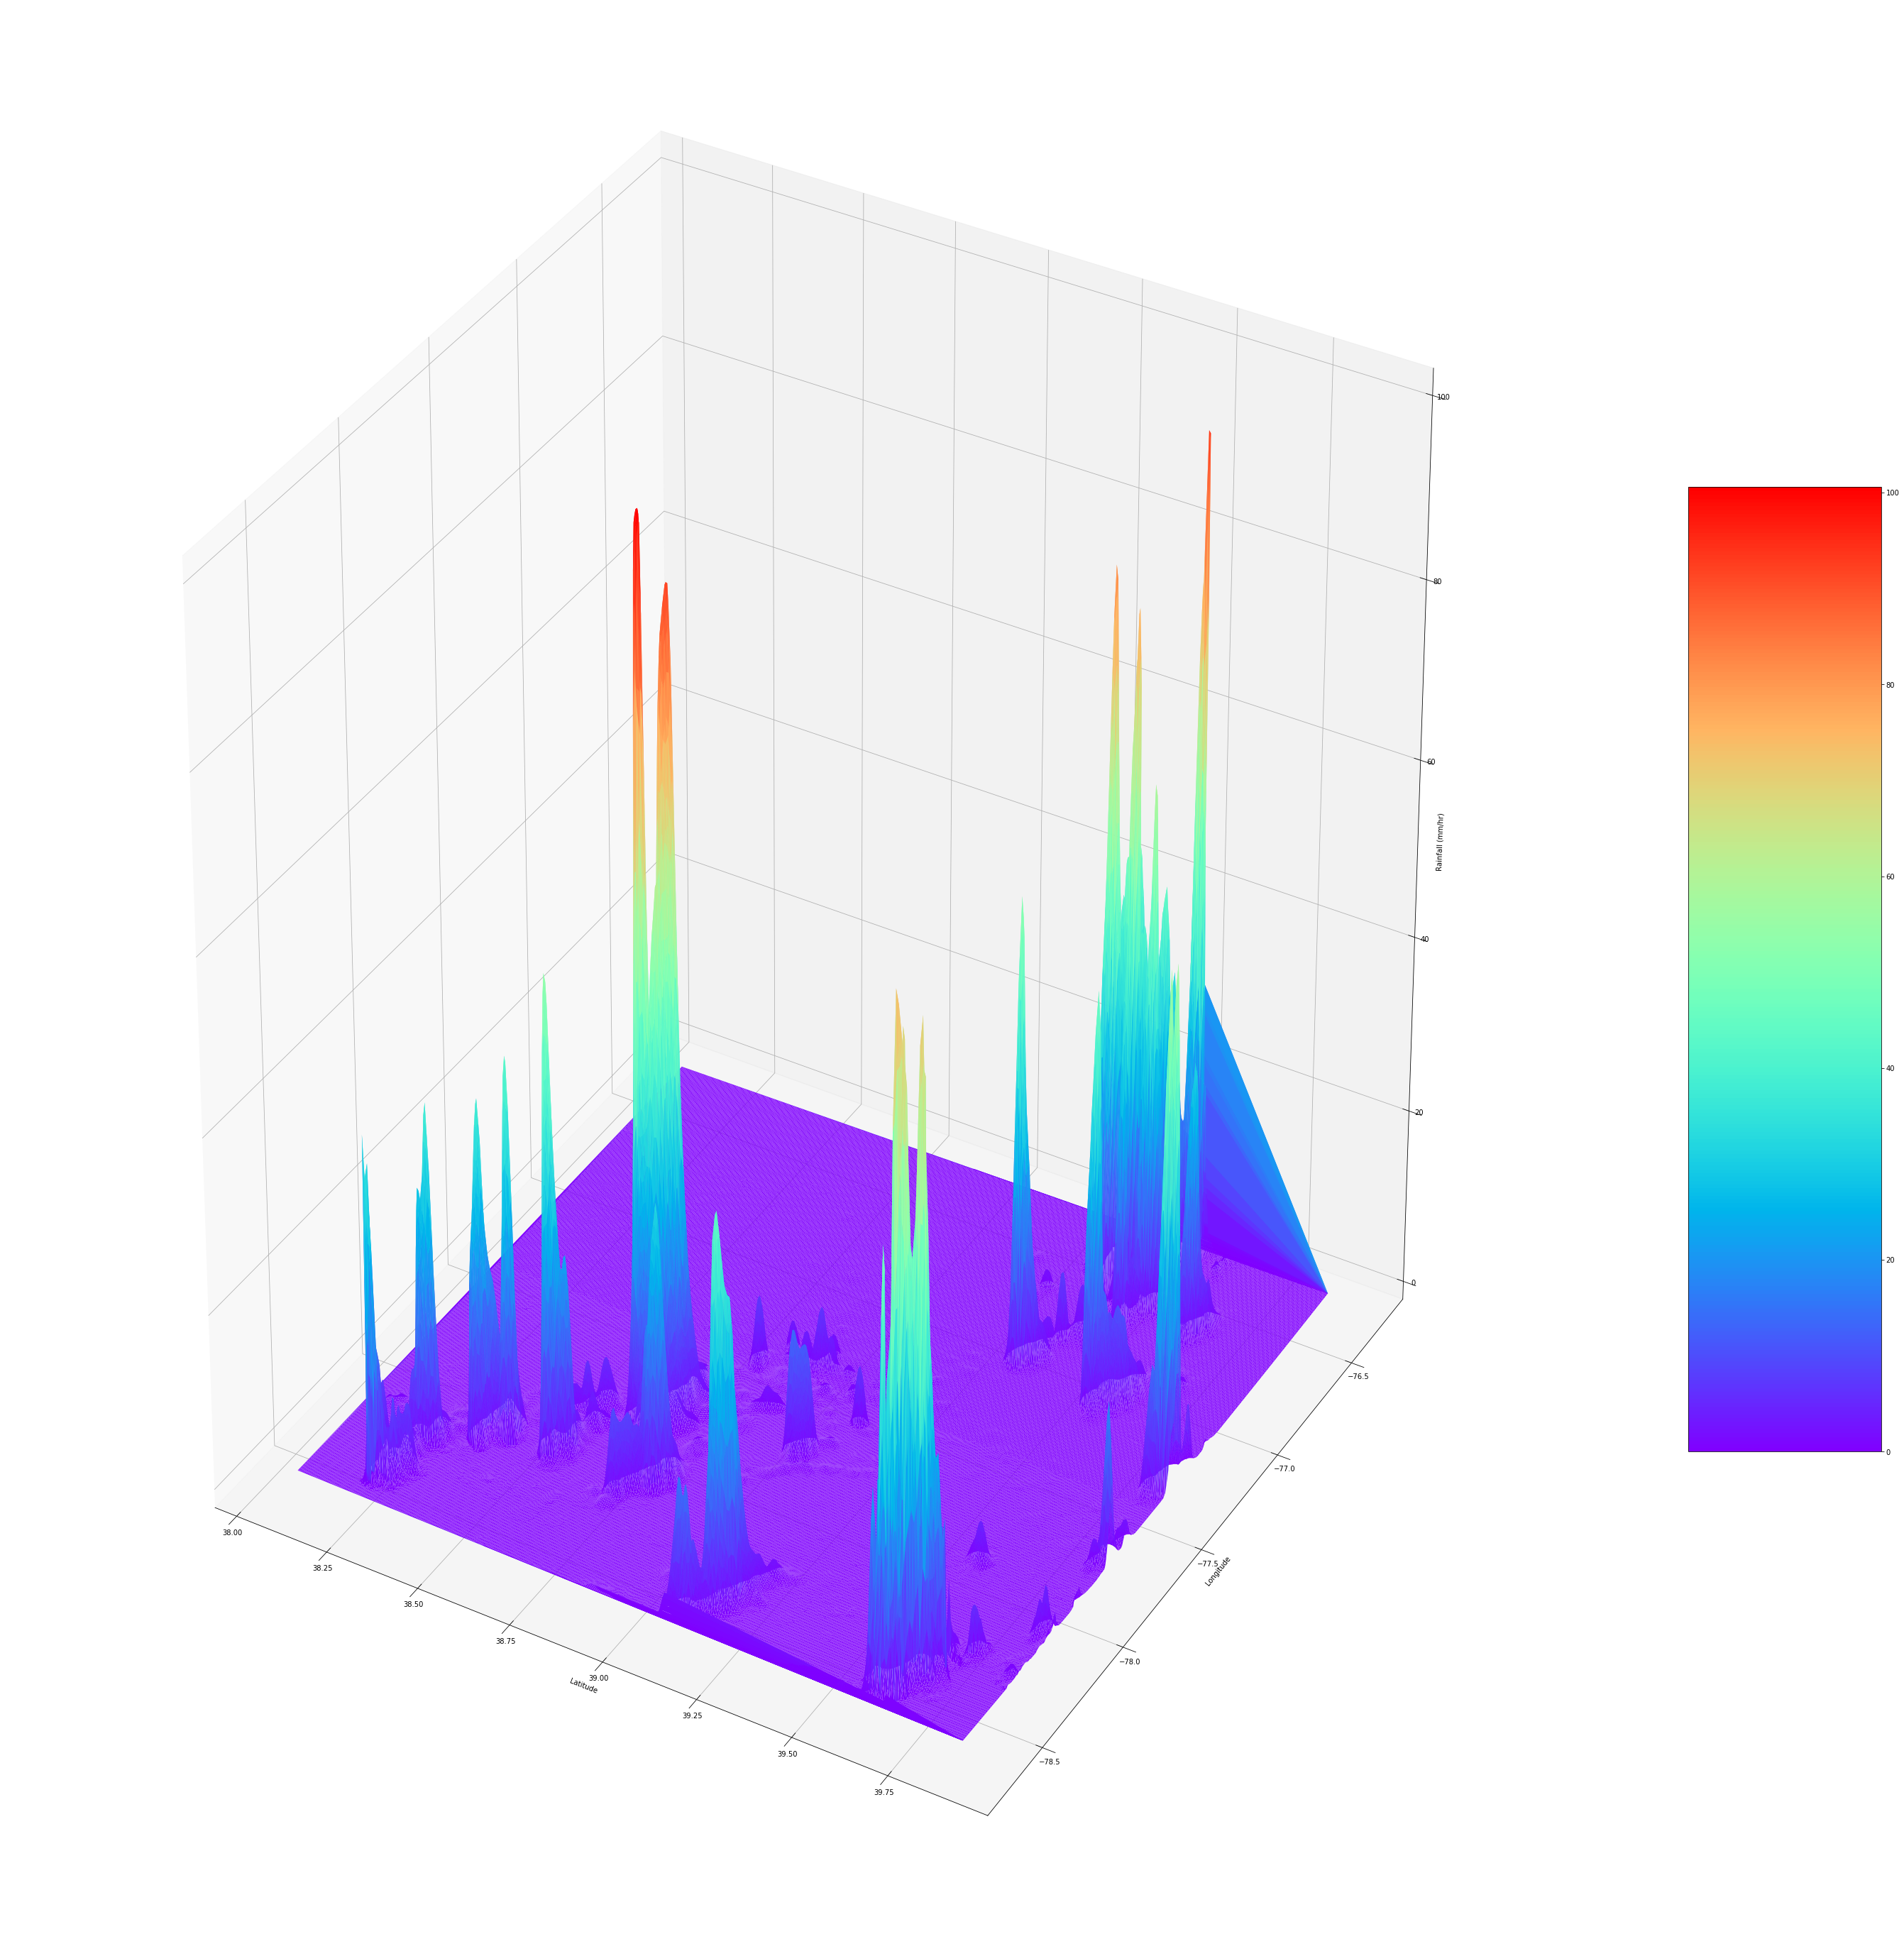

In [11]:
## Spatial Rain Rates
tdf = df[df.time == '2018-05-27 18:05:00']
# pd.crosstab(tdf.RR_Z, [tdf.lat, tdf.lon])
fig = plt.figure(figsize=(50,50))
ax = plt.axes(projection = '3d')
surf = ax.plot_trisurf(tdf.lat, tdf.lon, tdf.RR_Z, cmap='rainbow')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Rainfall (mm/hr)')
fig.colorbar(surf, shrink=0.5,aspect=5)
plt.show()

In [21]:
# Print Latitude Max and Mins to understand bounds
# print(ds18.lon.max())
# print(ds18.lon.min())
# print(ds18.lat.max())
# print(ds18.lat.min())

In [13]:
# Storm Peak
# ds18.time[51]

In [10]:
## Create Storm Imaging GIF and Spatial Imaging
ds = ds18
maxx = 150.
intt = 25.

Bounds_lat1 = 39.254064
Bounds_lat2 = 39.32305
Bounds_lon1 = -76.820775
Bounds_lon2 = -76.750778
EC_lon = -76.806
EC_lat = 39.275
time = ds.time[51]
for time in ds.time.values:
    
    fig,ax = plt.subplots(1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})

    lat = ds.lat.values
    lon = ds.lon.values

    ax.set_xlim(-76.750778,-76.820775)
    ax.set_xticks(np.arange(-76.750778,-76.820775,0.001))
    # ax.grid(axis = "x", color = "green", alpha = 0.3, linestyle = ":")
    ax.set_xlabel("Longitude")
    
    ax.set_ylim(39.254064,39.32305)
    ax.set_yticks(np.arange(39.254064,39.32305,0.05))
    ax.set_ylabel("Latitude")
    
    ax.grid(True)
    #ax.scatter(EC_lon, EC_lat, color='r', label='Ellicott City')
    #ax.legend()
    
    rain = ds.sel(time=time).RR_KDP.values
    timestring = str(time)
    ax.set_title('R(KDP) of Ellicott City '+timestring[:10]+' '+timestring[11:16], fontsize=14, fontweight='bold')
    ax.add_image(ShadedReliefESRI(), 12)
    levels = np.arange(intt,maxx+intt,intt)
    norm = matplotlib.colors.Normalize(vmin=0.0, vmax=maxx)
    cs = ax.contour(lon,lat,rain,levels=levels,norm=norm,extend='max')
    cbar_ax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    fig.colorbar(cs, cax=cbar_ax,label='mm/hr')

    fig.savefig('rain_rate_fields/RRKDP_'+timestring[:10]+'_'+timestring[11:13]+'_'+timestring[14:16],bbox_inches='tight')
    plt.cla()
    plt.close()
    plt.show()

In [15]:
# Check how to print timestrings for clarity
print(timestring[:10]+' '+timestring[11:16])


2018-05-28 02:00


In [17]:
# plot a single timestamp

# ds = ds18.sel(time='2018-05-27 22:20:00')
# maxx = 200.
# intt = 25.

# radar_lat = 38+(58./60.)+(31./3600.)
# radar_lon = -77-(28./60.)-(40./3600.)

# EC_lon = -76.806
# EC_lat = 39.275

# fig,ax = plt.subplots(1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})

# lat = ds.lat.values
# lon = ds.lon.values

# ax.set_xlim(lon.min(),lon.max())
# ax.set_ylim(lat.min(),lat.max())

# #ax.set_yticks(np.arange(40.0,42.0,0.25))
# #ax.set_xticks(np.arange(-77.,-75.,0.25))

# ax.grid(True)
# ax.scatter(EC_lon, EC_lat, color='r', label='Ellicott City')
# ax.legend()


# rain = ds.RR_Z.values
# timestring = str(time)
# ax.set_title('R(KDP) '+timestring[:10]+' '+timestring[11:16], fontsize=14, fontweight='bold')
# # ax.add_image(ShadedReliefESRI(), 12)
# levels = np.arange(intt,maxx+intt,intt)
# norm = matplotlib.colors.Normalize(vmin=0.0, vmax=maxx)
# cs = ax.contour(lon,lat,rain,levels=levels,norm=norm,extend='max')
# cbar_ax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
# fig.colorbar(cs, cax=cbar_ax,label='mm/hr')

# fig.savefig('rain_rate_fields/RRKDP_'+timestring[:10]+'_'+timestring[11:13]+'_'+timestring[14:16],bbox_inches='tight')
# plt.cla()
# plt.close()
# plt.show()

In [20]:
import imageio
import os
import glob
# make it into a gif
# start by getting filenames of images
filenames = []
for root, dirs, files in os.walk('rain_rate_fields/'):
    filenames += glob.glob(os.path.join(root, 'RRKDP*.png'))
filenames.sort()
# filenames

In [19]:
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('RR_KDP_fin.gif', images)